In [3]:
import warnings
import sys
import os

warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95'
sys.path.append('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')
os.chdir('/mnt/local/data/vtrifonov/prec-learning-Notay-loss/')

In [4]:
os.path.dirname(os.path.abspath('data.py'))

'/mnt/local/data/vtrifonov/prec-learning-Notay-loss'

In [5]:
import jax.numpy as jnp
from jax import random, vmap, clear_caches, jit
import numpy as np

import optax
from equinox.nn import Conv1d
import matplotlib.pyplot as plt
from functools import partial
from time import perf_counter

from data.dataset import dataset_qtt
from linsolve.cg import ConjGrad
from linsolve.precond import llt_prec_trig_solve, llt_inv_prec
from model import MessagePassing, FullyConnectedNet, PrecNet, ConstantConv1d, MessagePassingWithDot, CorrectionNet

from utils import params_count, asses_cond, iter_per_residual, batch_indices
from data.utils import direc_graph_from_linear_system_sparse
from train import train

plt.rcParams['figure.figsize'] = (11, 7)

ModuleNotFoundError: No module named 'data.dataset'

# Setup experiment

In [ ]:
pde = 'div_k_grad'      # 'poisson', 'div_k_grad'
grid = 64            # 32, 64, 128
variance = .7        # 0.1, 0.5, 1.0 1.5
lhs_type = 'l_ilu0'      # 'fd', 'ilu0', 'ilu1', 'ilu2', 'ict', 'l_ict', 'a_pow'
N_train = 1000
N_test = 200

fill_factor = 1     # int
threshold = 1e-4     # float
power = 2            # int
N_valid_CG = 100     # Number of CG iterations for validation in the very end

In [ ]:
with_cond = False
layer_ = Conv1d         # 'ConstantConv1d' to make a "zero" NN initialization; 'Conv1d' to make a random initialization
alpha = jnp.array([0.])

loss_type = 'llt'               # 'llt', 'llt-res', 'inv-prec'

In [ ]:
batch_size = 8
epoch_num = 1000
lr = 1e-3
schedule_params = None #[1700, 2001, 300, 1e-1]    # [start, stop, step, decay_size]

In [3]:
# if (loss_type in {'notay', 'llt-res', 'llt-res-norm'} and dataset == 'simple') or (loss_type in {'llt', 'llt-norm'} and dataset == 'krylov'):
#     raise ValueError('Not valid dataset for a chosen loss')

if schedule_params != None:
    assert len(schedule_params) == 4
    
    start, stop, step, decay_size = schedule_params
    steps_per_batch = N_train // batch_size
    start, stop, step = start*steps_per_batch, stop*steps_per_batch, step*steps_per_batch
    lr = optax.piecewise_constant_schedule(
        lr,
        {k: v for k, v in zip(np.arange(start, stop, step), [decay_size, ] * len(jnp.arange(start, stop, step)))}
    )

NameError: name 'schedule_params' is not defined

In [4]:
model_config = {
    'node_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_enc': {
        'features': [1, 16, 16],
        'N_layers': 2,
        'layer_': layer_
    },
    'edge_dec': {
        'features': [16, 16, 1],
        'N_layers': 2,
        'layer_': layer_
    },
    'mp': {
        'edge_upd': {
            'features': [48, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'node_upd': {
            'features': [32, 16, 16],
            'N_layers': 2,
            'layer_': layer_
        },
        'mp_rounds': 5
    }
}

NameError: name 'layer_' is not defined

# Make dataset

In [8]:
s1 = perf_counter()
A_train, A_pad_train, b_train, u_exact_train, bi_edges_train = dataset_qtt(pde, grid, variance, lhs_type, return_train=True, N_samples=N_train, fill_factor=fill_factor, threshold=threshold, power=power)
A_test, A_pad_test, b_test, u_exact_test, bi_edges_test = dataset_qtt(pde, grid, variance, lhs_type, return_train=False, N_samples=N_test, fill_factor=fill_factor, threshold=threshold, power=power)
print(perf_counter() - s1)

16.70894417099771


In [9]:
# A_pad_train[80, ...].indices[300, :]

In [10]:
# plt.rcParams['figure.figsize'] = (11, 7)
# start, stop = 300, 350
# start_im = 45
# stop_im = start_im + 64

# for j, ind in enumerate(bi_edges_train[80, start:stop, :]):
#     A_loc = A_pad_train[80, ...]
#     A_loc.data = A_loc.data * 0 + 1
#     A_loc.data = A_loc.data.at[ind].set(5)
#     plt.imshow(A_loc[start_im:stop_im, start_im:stop_im].todense())
#     plt.axis(False)
#     plt.show()
    
#     if j == 64: break

# Train model

In [11]:
seed = 42
NodeEncoder = FullyConnectedNet(**model_config['node_enc'], key=random.PRNGKey(seed))
EdgeEncoder = FullyConnectedNet(**model_config['edge_enc'], key=random.PRNGKey(seed))
EdgeDecoder = FullyConnectedNet(**model_config['edge_dec'], key=random.PRNGKey(seed))

mp_rounds = 5
MessagePass = MessagePassing(
    update_edge_fn = FullyConnectedNet(**model_config['mp']['edge_upd'], key=random.PRNGKey(seed)),    
    update_node_fn = FullyConnectedNet(**model_config['mp']['node_upd'], key=random.PRNGKey(seed)),
    mp_rounds=model_config['mp']['mp_rounds']
)

# model = PrecNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
#                 EdgeDecoder=EdgeDecoder, MessagePass=MessagePass)


model = CorrectionNet(NodeEncoder=NodeEncoder, EdgeEncoder=EdgeEncoder, 
                EdgeDecoder=EdgeDecoder, MessagePass=MessagePass, alpha=alpha)
print(f'Parameter number: {params_count(model)}')

Parameter number: 2754


In [12]:
# data = (X_train, X_test, y_train, y_test)
data = (
    [A_train, A_pad_train, b_train, bi_edges_train, u_exact_train],
    [A_test, A_pad_test, b_test, bi_edges_test, u_exact_test],
    jnp.array([1]), jnp.array([1])
)
train_config = {
    'optimizer': optax.adam,
    'lr': lr,
    'optim_params': {},#{'weight_decay': 1e-8}, 
    'epoch_num': epoch_num,
    'batch_size': batch_size,
}

In [13]:
s = perf_counter()
model, losses = train(model, data, train_config, loss_name=loss_type, repeat_step=1, with_cond=with_cond)
dt = perf_counter() - s

In [14]:
dt

1602.2642796559958

In [15]:
print('alpha:', end='')
model.alpha

alpha:

Array([-0.04967778], dtype=float32)

In [16]:
nodes, edges, receivers, senders, _ = direc_graph_from_linear_system_sparse(A_pad_test, b_test)
lhs_nodes, lhs_edges, lhs_receivers, lhs_senders, _ = direc_graph_from_linear_system_sparse(A_test, b_test)

L = vmap(model, in_axes=((0, 0, 0, 0), 0, (0, 0, 0, 0)), out_axes=(0))((nodes, edges, receivers, senders), bi_edges_test, (lhs_nodes, lhs_edges, lhs_receivers, lhs_senders))
del model, data, A_train, A_pad_train, b_train, u_exact_train, bi_edges_train, bi_edges_test
clear_caches()

Final values
  train loss: 471.7174
   test loss: 458.8612
    LLT cond: 1

Minimim test loss `457.8781` at epoch `986`

Minimim test P^(-1)A cond `1` at epoch `0`


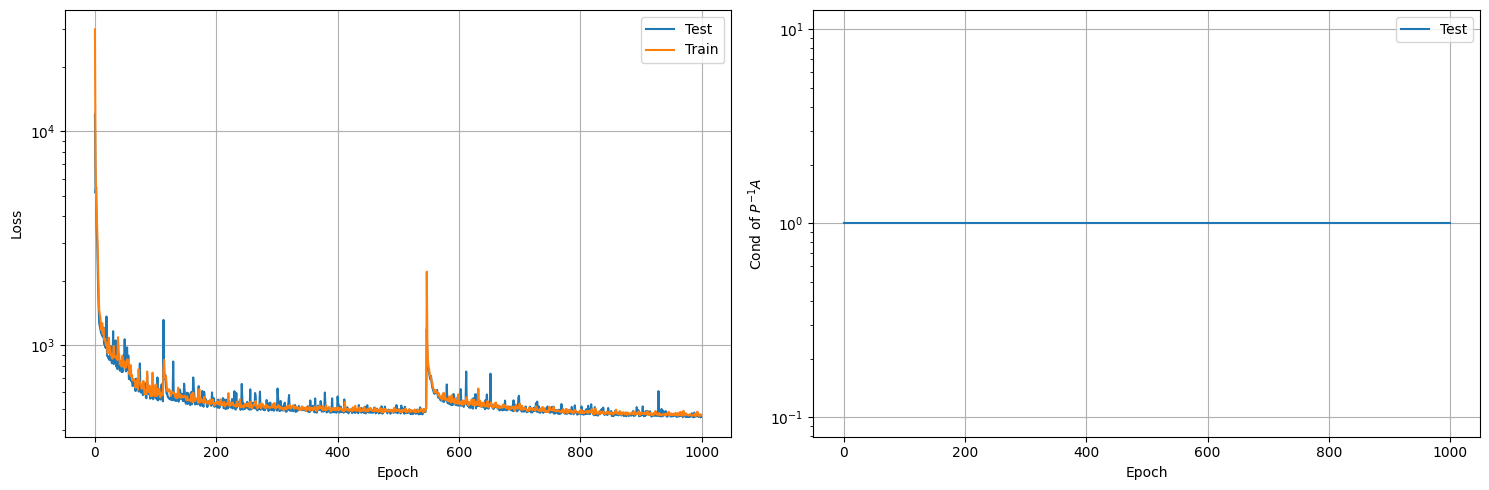

In [17]:
_, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(len(losses[0])), losses[1], label='Test')
axes[0].plot(range(len(losses[0])), losses[0], label='Train')
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss');
axes[0].grid();

axes[1].plot(range(len(losses[0])), losses[2], label='Test')
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cond of $P^{-1}A$')
axes[1].grid();

plt.tight_layout()

print(f'Final values\n  train loss: {losses[0][-1]:.4f}\n   test loss: {losses[1][-1]:.4f}\n    LLT cond: {losses[2][-1]:.0f}')
print(f'\nMinimim test loss `{jnp.min(losses[1]).item():.4f}` at epoch `{jnp.argmin(losses[1]).item():.0f}`')
print(f'\nMinimim test P^(-1)A cond `{jnp.min(losses[2]).item():.0f}` at epoch `{jnp.argmin(losses[2]).item():.0f}`')

In [18]:
import ilupp
from utils import jBCOO_to_scipyCSR, asses_cond_with_res
import jax.experimental.sparse as jsparse

cg = partial(ConjGrad, prec_func=partial(llt_prec_trig_solve, L=L[0, ...][None, ...]))
print('Approx cond with constructed:', asses_cond_with_res(A_test[0:1, ...], b_test[0:1, ...], cg))

cg = partial(ConjGrad, prec_func=partial(llt_prec_trig_solve, L=jsparse.BCOO.from_scipy_sparse(ilupp.ichol0(jBCOO_to_scipyCSR(A_test[0, ...])))[None, ...]))
print('Approx cond with IC(0):      ', asses_cond_with_res(A_test[0:1, ...], b_test[0:1, ...], cg))

Approx cond with constructed: 12.1804
Approx cond with IC(0):       20.955906


# Apply model to CG

In [19]:
# Not preconditioned
X_I, R_I = ConjGrad(A_test, b_test, N_iter=N_valid_CG, prec_func=None, seed=42)

In [20]:
if loss_type != 'inv-prec':
    # P = LL^T
    prec = partial(llt_prec_trig_solve, L=L)
else:
    # P^{-1} = LL^T
    prec = partial(llt_inv_prec, L=L)

s_prec = perf_counter()
X_LLT, R_LLT = ConjGrad(A_test, b_test, N_iter=N_valid_CG, prec_func=prec, seed=42)
print(perf_counter() - s_prec)

61.55771726500825


In [21]:
# print(A_pad_test.shape)
# a = A_pad_test[0, :100, :100]
# a.data = a.data * 0 + 1
# plt.imshow(a.todense())

 CG: {0.001: nan, 1e-06: nan, 1e-09: nan, 1e-12: nan}
PCG: {0.001: 46, 1e-06: 60, 1e-09: 77, 1e-12: 91}


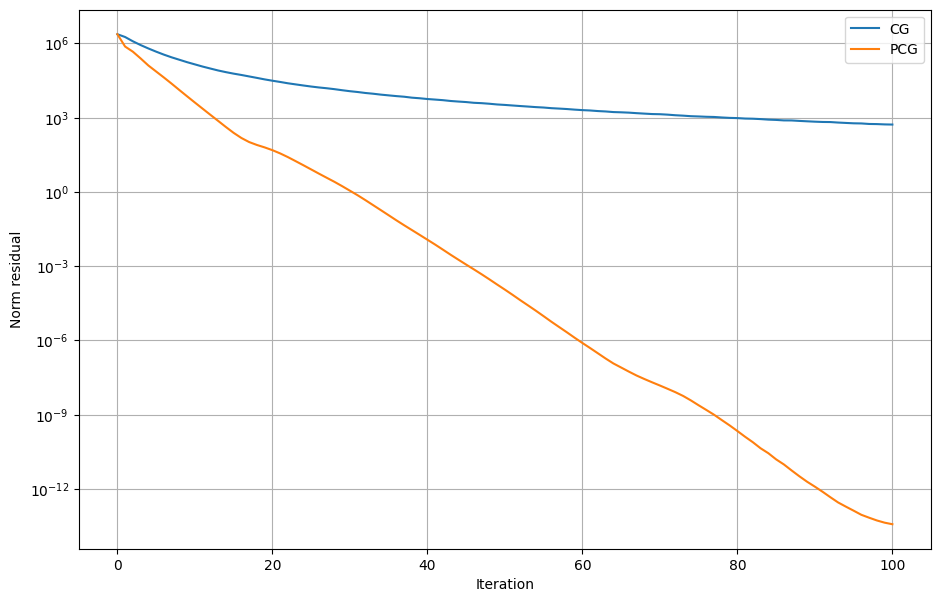

In [22]:
plt.plot(range(R_I.shape[-1]), jnp.linalg.norm(R_I, axis=1).mean(0), label="CG")
plt.plot(range(R_LLT.shape[-1]), jnp.linalg.norm(R_LLT, axis=1).mean(0), label="PCG")

plt.xlabel('Iteration')
plt.ylabel('Norm residual')
plt.legend();
plt.yscale('log')
plt.grid();
    
res_I_dict = iter_per_residual(jnp.linalg.norm(R_I, axis=1).mean(0))
res_LLT_dict = iter_per_residual(jnp.linalg.norm(R_LLT, axis=1).mean(0))
print(' CG:', res_I_dict)
print('PCG:', res_LLT_dict)

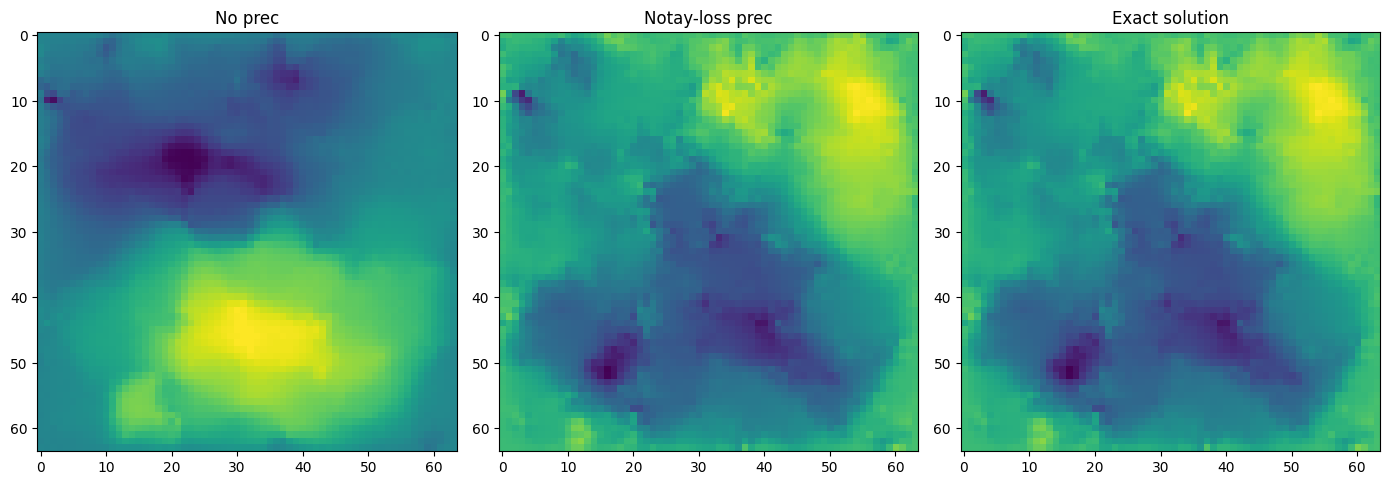

In [23]:
_, axes = plt.subplots(1, 3, figsize=(14, 14))

axes[0].imshow(X_I[0, :, -1].reshape([grid]*2))
axes[1].imshow(X_LLT[0, :, -1].reshape([grid]*2))
axes[2].imshow(u_exact_test[0, :].reshape([grid]*2))

axes[0].set_title('No prec')
axes[1].set_title('Notay-loss prec')
axes[2].set_title('Exact solution')

plt.tight_layout()

[66, 66, 157, 66]


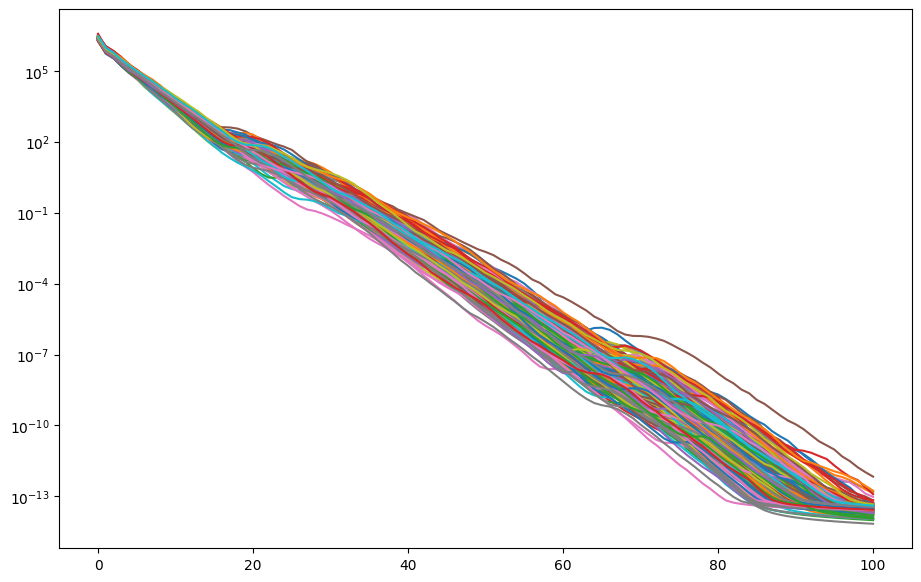

In [24]:
res_shape = jnp.linalg.norm(R_LLT, axis=1).shape
ls1e_3, ls1e_6, ls1e_9, ls1e_12 = [], [], [], []

for i in range(res_shape[0]):
    abc = iter_per_residual(jnp.linalg.norm(R_LLT, axis=1)[i, ...])
    for n, ls_ in zip([1e-3, 1e-6, 1e-9, 1e-12], [ls1e_3, ls1e_6, ls1e_9, ls1e_12]):
        ls_.append(abc[n])
    plt.plot(range(res_shape[1]), jnp.linalg.norm(R_LLT, axis=1)[i, ...], label=i)
plt.yscale('log')

print([np.argmin(ls_) for ls_ in [ls1e_3, ls1e_6, ls1e_9, ls1e_12]])

In [25]:
import scipy

In [34]:
# cherry-pick: 66
A_chp = jBCOO_to_scipyCSR(A_test[66, ...])
L_gnn_chp = jBCOO_to_scipyCSR(L[66, ...])
L_ichol_chp = ilupp.ichol0(A_chp)

In [39]:
# Cond
print('Cond lhs', np.linalg.cond(A_chp.todense()))

prec_gnn = scipy.sparse.linalg.inv(L_gnn_chp @ L_gnn_chp.T)
prec_ic0 = scipy.sparse.linalg.inv(L_ichol_chp @ L_ichol_chp.T)

A_gnn = (prec_gnn @ A_chp).todense()
A_ic0 = (prec_ic0 @ A_chp).todense()

print('Cond lhs + GNN', np.linalg.cond(A_gnn))
print('Cond lhs + IC(0)', jnp.linalg.cond(A_ic0))

Cond lhs 15887.863251694927
Cond lhs + GNN 55.1754539406055
Cond lhs + IC(0) 270.211


In [40]:
A_eigen = np.abs(np.linalg.eigvals(A_chp.todense()))
A_ggn_eigen = np.abs(np.linalg.eigvals(A_gnn))
A_ic0_eigen = np.abs(np.linalg.eigvals(A_ic0))

print('Spectrum lhs, max:', A_eigen.max(), ', min:', A_eigen.min())
print('Spectrum lhs + GNN, max:', A_ggn_eigen.max(), ', min:', A_ggn_eigen.min())
print('Spectrum lhs + IC(0), max:', A_ic0_eigen.max(), ', min:', A_ic0_eigen.min())

Spectrum lhs, max: 344834.4099597118 , min: 21.70426598594807
Spectrum lhs + GNN, max: 7.207446670668473 , min: 0.23237928606833896
Spectrum lhs + IC(0), max: 1.2197150280082272 , min: 0.005513668796694446


In [51]:
def loss_8(L, Ainv):
    return np.square(np.linalg.norm(L @ L.T @ Ainv - np.eye(Ainv.shape[0]), ord='fro'))

def loss_7(L, x=u_exact_test[32, ...], b=b_test[32, ...]):
    return np.square(np.linalg.norm(L @ (L.T @ x) - b, ord=2))    

In [52]:
print('Loss [8] lhs + GNN, max:', loss_8(L_gnn_chp, scipy.sparse.linalg.inv(A_chp)))
print('Loss [8] lhs + IC(0), max:', loss_8(L_ichol_chp, scipy.sparse.linalg.inv(A_chp)))
print()
print('Loss [7] lhs + GNN, max:', loss_7(L_gnn_chp))
print('Loss [7] lhs + IC(0), max:', loss_7(L_ichol_chp))

Loss [8] lhs + GNN, max: 447.7299913814039
Loss [8] lhs + IC(0), max: 69444.94196906117

Loss [7] lhs + GNN, max: 33859.246
Loss [7] lhs + IC(0), max: 129955.39


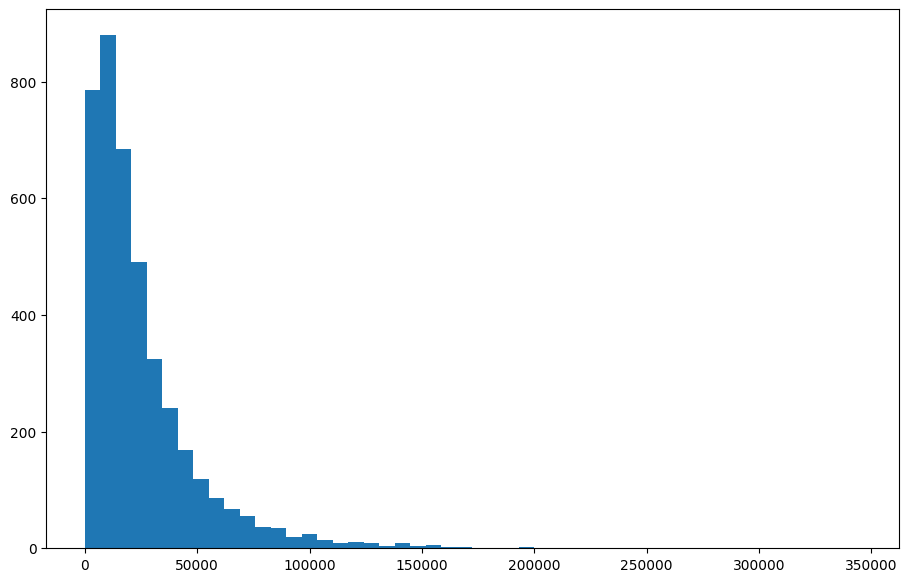

In [81]:
plt.hist(A_eigen, bins=50);

In [74]:
np.where(A_ggn_eigen < 0.58113266)

(array([286, 391, 451, 535]),)

In [78]:
A_ggn_eigen[np.argwhere(A_ggn_eigen < 0.58113266)]

array([[0.23237929],
       [0.43064217],
       [0.52259653],
       [0.54317383]])

In [71]:
A_ggn_eigen

array([7.20744667, 7.07968119, 6.9272684 , ..., 0.93769171, 0.93767748,
       0.93342138])

Text(0.5, 1.0, 'A')

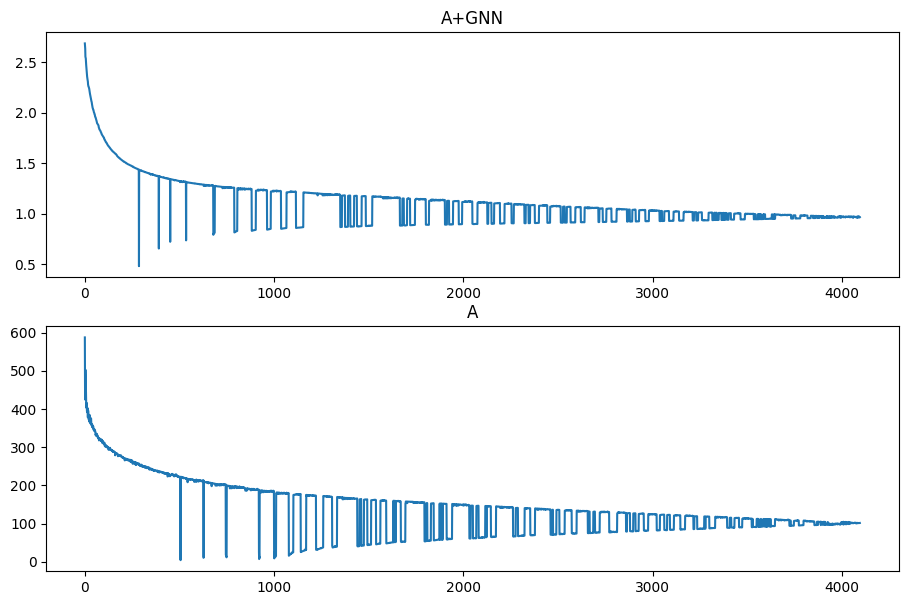

In [91]:
plt.subplot(2, 1, 1)
plt.plot(range(A_ggn_eigen.shape[0]), np.sqrt(A_ggn_eigen));
plt.title('A+GNN')

plt.subplot(2, 1, 2)
plt.plot(range(A_eigen.shape[0]), np.sqrt(A_eigen))
plt.title('A')

In [ ]:
64, 0.5 -> 128, 0.5:
{0.001: 75, 1e-06: 97, 1e-09: 123, 1e-12: 147}

64, 0.5 -> 64, 0.7:
{0.001: 45, 1e-06: 58, 1e-09: 74, 1e-12: 88}

64, 0.5 -> 128, 0.7:
{0.001: 86, 1e-06: 113, 1e-09: 140, 1e-12: 168}

64, 0.5 -> 128, 0.1:
{0.001: 53, 1e-06: 67, 1e-09: 86, 1e-12: 101}

64, 0.5 -> 64, 0.1:
{0.001: 35, 1e-06: 46, 1e-09: 57, 1e-12: 68}

64, 0.5 -> 32, 0.5:
{0.001: 31, 1e-06: 41, 1e-09: 53, 1e-12: 64}

64, 0.5 -> 32, 0.7:
{0.001: 34, 1e-06: 45, 1e-09: 57, 1e-12: 69}

64, 0.5 -> 32, 0.1:
{0.001: 27, 1e-06: 36, 1e-09: 46, 1e-12: 55}

In [191]:
transfer_32_01 = {'1e-3': 27, 1e-6: 36, 1e-9: 46, 1e-12: 55}
transfer_32_05 = {'1e-3': 31, 1e-6: 41, 1e-9: 53, 1e-12: 64}
transfer_32_07 = {'1e-3': 34, 1e-6: 45, 1e-9: 57, 1e-12: 69}
transfer_64_01 = {'1e-3': 35, 1e-6: 46, 1e-9: 57, 1e-12: 68}
transfer_64_07 = {'1e-3': 45, 1e-6: 58, 1e-9: 74, 1e-12: 88}
transfer_128_01 = {'1e-3': 53, 1e-6: 67, 1e-9: 86, 1e-12: 101}
transfer_128_05 = {'1e-3': 75, 1e-6: 97, 1e-9: 123, 1e-12: 147}
transfer_128_07 = {'1e-3': 86, 1e-6: 113, 1e-9: 140, 1e-12: 168}
transfer = [[transfer_32_01, transfer_32_05, transfer_32_07],
            [transfer_64_01, {'1e-3': 'Transfer', 1e-6: 'Transfer', 1e-9: 'Transfer', 1e-12: 'Transfer'}, transfer_64_07],
            [transfer_128_01, transfer_128_05, transfer_128_07]]

real_32_01 = [22, 30, 37, 46]
real_32_05 = [26, 34, 43, 52]
real_32_07 = [27, 36, 46, 55]
real_64_01 = [32, 44, 57, 66]
real_64_07 = [45, 59, 76, 89]
real_128_01 = [52, 66, 84, 98]
real_128_05 = [68, 89, 115, 136]
real_128_07 = [76, 99, 125, 149]
real = [[real_32_01, real_32_05, real_32_07],
        [real_64_01, ['Trained', 'Trained', 'Trained', 'Trained'], real_64_07],
        [real_128_01, real_128_05, real_128_07]]

ic0_32_01 = [33, 43, 55, 66]
ic0_32_05 = [38, 49, 62, 75]
ic0_32_07 = [40, 51, 66, 79]
ic0_64_01 = [66, 85, 108, 130]
ic0_64_07 = [80, 102, 130, 155]
ic0_128_01 = [133, 170, 216, 258]
ic0_128_05 = [149, 194, 246, 290]
ic0_128_07 = [160, 209, 261, 307]
ic0 = [[ic0_32_01, ic0_32_05, ic0_32_07],
       [ic0_64_01, ['IC(0)', 'IC(0)', 'IC(0)', 'IC(0)'], ic0_64_07],
       [ic0_128_01, ic0_128_05, ic0_128_07]]

In [192]:
grids = [32, 64, 128]
var = [0.1, 0.5, 0.7]
tols = ['1e-3', 1e-6, 1e-9, 1e-12]

In [199]:
lines = [
    [-.5, -.3],
    [0.3, 0.7],
    [1.3, 1.7],
    [2.3, 2.5]
]

In [3]:
plt.rcParams['font.size'] = 20
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)
axes = axes.flatten()

for k, t in enumerate(tols):
    for i, g in enumerate(grids):
        for j, v in enumerate(var):
#             if g == 64 and var == 0.5:
#             text = str(transfer[i][j][t])
#             text = r'$\alpha$'
#             else:
#                 text = r'\underline{'+str(transfer[i][j][t])+'}'
#             print('k', k, ' i', i , ' j', j, sep='')
            axes[k].text(i, j+0.2,     ic0[i][j][k], color='royalblue', ha='center', va='center', fontsize=20)
            axes[k].text(i, j, real[i][j][k], color='k', ha='center', va='center', fontsize=22)
            axes[k].text(i, j-0.2, transfer[i][j][t], color='firebrick', ha='center', va='center', fontsize=20)
    axes[k].set_xticks(range(3), grids)
    axes[k].set_yticks(range(3), var)
    axes[k].set_title(t)
    axes[k].set_xlim(-.5, 2.5)
    axes[k].set_ylim(-.5, 2.5)
    for l in lines:
        axes[k].vlines([0, 1, 2], *l, color='k', linewidth=.3)
        axes[k].hlines([0, 1, 2], *l, color='k', linewidth=.3)
#     axes[k].vlines([0, 1, 2], -.5, 2.5)
#     axes[k].hlines([0, 1, 2], -.5, 2.5)

fig.supylabel("Variance")
fig.supxlabel("Grid")
plt.tight_layout()
plt.show();

NameError: name 'tols' is not defined

Error in callback <function _draw_all_if_interactive at 0x7fb81f6972e0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1500x1500 with 4 Axes>